In [7]:
import os
import logging, os

logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [19]:
from matplotlib import pyplot as plt
from musicnet.utils import Track, get_train_ids, instruments_vocab, notes_vocab
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from glob import glob
from musicnet.models.transformer.Transformer import TransformerLRSchedule, WarmupLRSchedule
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.nn import weighted_cross_entropy_with_logits
from musicnet.preprocessing.midi_to_wav.utils import MidiConvertedTrack, get_midi_train_ids
from musicnet.preprocessing.wav_specs_and_notes.utils import load_params, Preprocessor, create_tf_record_ds
import mido

In [20]:
tf.__version__

'2.17.0-rc1'

In [21]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
params = load_params()

In [23]:
print(params)

{'use_converted_midis': True, 'instruments_whitelist': [1], 'preprocessor': {'chunk_size_sec': 10, 'chunk_shift_sec': 5, 'target_sr': 44100, 'note_rounding': 0.01, 'n_fft': 2205, 'hop_length': 441, 'min_hz': 0, 'n_filters': 200, 'unit': 'amplitude'}, 'datasets': {'train': {'size': 5000, 'file_count': 30}, 'val': {'size': 1000, 'file_count': 10}}}


In [24]:
if params["instruments_whitelist"]:
    instruments_vocab = { v: k for k, v in enumerate(params["instruments_whitelist"]) }

In [27]:
ds_params = {
    "n_filters": params["preprocessor"]["n_filters"],
    "target_classes": len(instruments_vocab) * len(notes_vocab),
    "batch_size": 8,
}
train_ds = create_tf_record_ds("train", **ds_params)

I0000 00:00:1721071767.062717  561339 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721071767.062894  561339 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721071767.062991  561339 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721071767.135271  561339 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [28]:
for batch in train_ds:
    print(batch)
    break

2024-07-15 21:30:05.564468: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes at component 0: expected [?,?,200] but got [8,998,100].


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes at component 0: expected [?,?,200] but got [8,998,100]. [Op:IteratorGetNext] name: 

: 

In [15]:
id = get_midi_train_ids()[-1]
track = MidiConvertedTrack(id)
preprocessor = Preprocessor(**params["preprocessor"], ins)
x_chunks, y_chunks = preprocessor.preprocess(track)

TypeError: Preprocessor.__init__() missing 1 required positional argument: 'instruments_vocab'

In [182]:
print(x_chunks.shape, y_chunks.shape)

(67, 998, 100) (67, 1000, 913)


In [183]:
track.get_metadata()

composer                                 Dvorak
composition     String Quartet No 12 in F major
movement        4. Finale: vivace ma non troppo
ensemble                         String Quartet
source                                 Museopen
transcriber                      Masahiro Ishii
catalog_name                               OP96
seconds                                     351
Name: 1933, dtype: object

In [184]:
track.get_midi_path()

'/home/leszek/projects/musicnet/data/MusicNet/musicnet_midis/musicnet_midis/Dvorak/1933_dv96_4.mid'

In [185]:
notes = track.read_midi_notes()

In [186]:
len(notes)

5344

In [141]:
# mid = mido.MidiFile(track.get_midi_path())

# i = 0
# for msg in mid:
#     # if msg.type == "control_change" or msg.type == "program_change":
#     #     print(msg)
#     if msg.type == "note_on":
#         print(msg)

In [187]:
midi_notes = track.read_midi_notes()

In [188]:
print(midi_notes.iloc[10:])
print(midi_notes.iloc[-10:])

      note  channel  program  start_time    end_time
10      53        4       41    1.776317    1.894738
11      57        2       40    1.973685    2.092106
12      53        4       41    1.973685    2.092106
13      53        7       45    1.973685    2.131580
14      57        2       40    2.171053    2.289475
...    ...      ...      ...         ...         ...
5339    60        2       40  320.107465  321.177465
5340    53        4       41  320.107465  321.177465
5341    41        6       42  320.107465  321.177465
5342    69        0       40  320.107465  321.227465
5343    41        6       42  326.027465  327.947465

[5334 rows x 5 columns]
      note  channel  program  start_time    end_time
5334    69        0       40  319.530145  320.045609
5335    65        0       40  319.530145  320.045609
5336    41        6       42  319.530145  320.045609
5337    65        0       40  320.107465  321.177465
5338    65        2       40  320.107465  321.177465
5339    60        2  

In [189]:
csv_data = track.read_csv_data()

print(csv_data.iloc[:10])
print(csv_data.iloc[-10:])

   start_time  end_time  instrument  ...  start_beat  end_beat         note_value
0        9182     17374          42  ...        2.00      0.60             Eighth
1        9182     17374          41  ...        2.00      0.60             Eighth
2       18398     20446          41  ...        2.75      0.15  Triplet Sixteenth
3       18398     20446          42  ...        2.75      0.15  Triplet Sixteenth
4       22494     27614          42  ...        3.00      0.30            Triplet
5       22494     27614          41  ...        3.00      0.30            Triplet
6       31198     45022          41  ...        3.50      0.80      Dotted Eighth
7       31198     45022          42  ...        3.50      0.80      Dotted Eighth
8       48606     53725          41  ...        4.50      0.30            Triplet
9       48606     53725          42  ...        4.50      0.30            Triplet

[10 rows x 7 columns]
      start_time  end_time  instrument  note  start_beat  end_beat note_val

In [190]:
np.array(sorted(csv_data["instrument"].unique()))

array([41, 42, 43])

In [191]:
np.array(sorted(midi_notes["program"].unique()))

array([40, 41, 42, 45], dtype=int8)

In [192]:
# print(csv_data["instrument"].unique())

In [193]:
# print(instruments_vocab)

In [194]:
print(x_chunks.shape, y_chunks.shape)

(67, 998, 100) (67, 1000, 913)


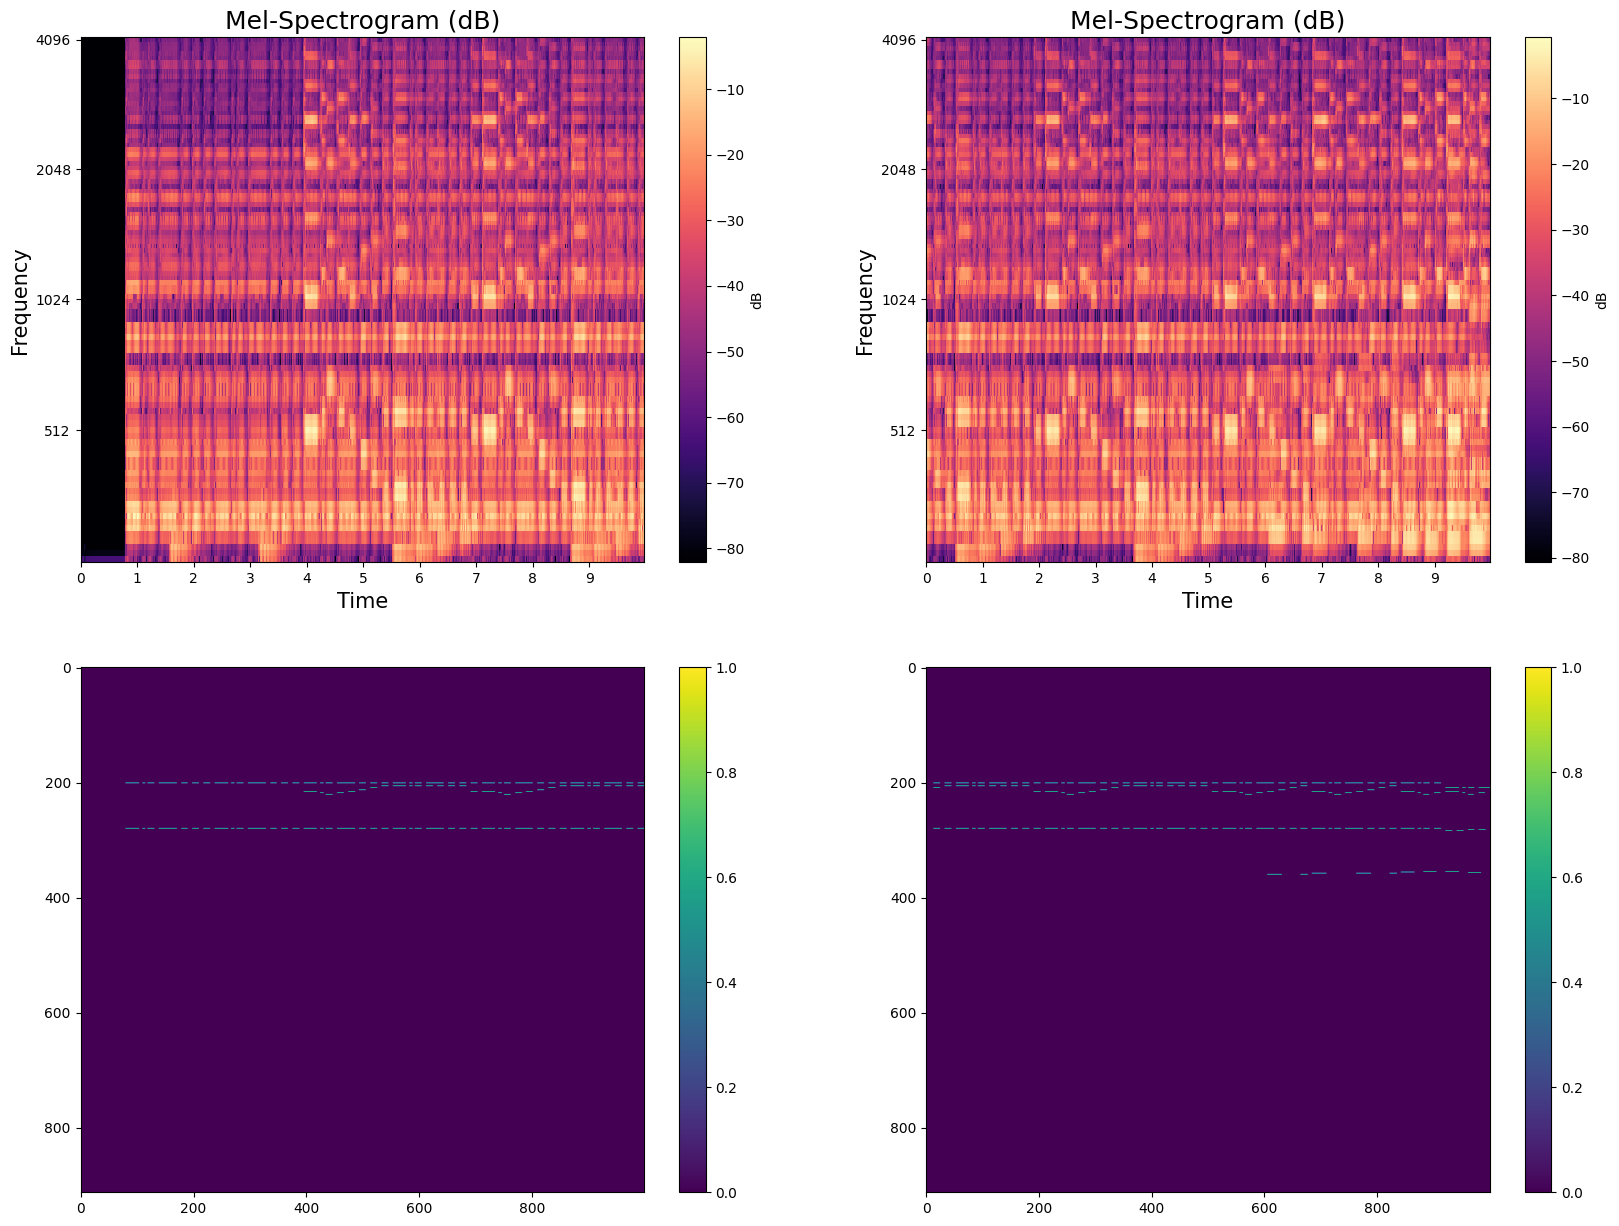

In [200]:
plt.figure(figsize=(20, 15))

for i in range(0, 2):
    plt.subplot(2, 2, i+1)
    librosa.display.specshow(
        x_chunks[i].T,
        sr=params["preprocessor"]["target_sr"],
        x_axis="time",
        y_axis="mel",
        hop_length=params["preprocessor"]["hop_length"],
        fmin=16,
        fmax=4096
    )
    plt.colorbar(label="dB")
    plt.title('Mel-Spectrogram (dB)', fontdict=dict(size=18))
    plt.xlabel('Time', fontdict=dict(size=15))
    plt.ylabel('Frequency', fontdict=dict(size=15))

for i in range(0, 2):
    plt.subplot(2, 2, i+3)
    plt.imshow(y_chunks[i].T, aspect="auto")
    plt.colorbar()

In [30]:
y_pred = np.array([
    [ # First sequence
        [0.7, 0, 0, 0],
        [0.7, 0, 0.7, 0.7],
        [0, 0, 0, 0],
        [0, 0.7, 0, 0]
    ],
    [ # Second sequence
        [0.7, 0.7, 0.7, 0.7],
        [0, 0, 0, 0],
        [0.7, 0.7, 0.7, 0.7],
        [0, 0, 0, 0]
    ]
])

y_true = np.array([
    [ # First sequence
        [1, 0, 0, 0],
        [1, 1, 1, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 1]
    ],
    [ # Second sequence
        [0, 1, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 1]
    ] 
])
f1 = keras.metrics.F1Score(threshold=0.5, average="macro")
f1.update_state(y_true.reshape(-1, 4), y_pred.reshape(-1, 4))

f1s = []
for c in range(0, 4):
    # Calculate precision, recall and f1 separately for each class:
    y_pred_c = y_pred[:, :, c].flatten()
    y_true_c = y_true[:, :, c].flatten()
    f1_c = f1_score(y_true_c, y_pred_c > 0.5)
    f1s.append(f1_c)
    print(c, {
        "precision":precision_score(y_true_c, y_pred_c > 0.5),
        "recall": recall_score(y_true_c, y_pred_c > 0.5),
        "f1": f1_c
    })

print("Final result: ", f1.result())
print("Avg f1:", np.mean(f1s))

0 {'precision': 0.5, 'recall': 0.5, 'f1': 0.5}
1 {'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1': 0.6666666666666666}
2 {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
3 {'precision': 0.6666666666666666, 'recall': 0.4, 'f1': 0.5}
Final result:  tf.Tensor(0.6666666, shape=(), dtype=float32)
Avg f1: 0.6666666666666666


In [48]:
inputs = np.array([
    [
        [10, 0.1],
        [20, 0.05],
        [40, 0.1],
        [20, 0.2],
        [10, 0.1]
    ],
    [
        [15, 0.05],
        [25, 0.03],
        [40, 0.1],
        [20, 0.2],
        [35, 0.15]
    ]
], dtype=np.float64)
bn = keras.layers.BatchNormalization(epsilon=1e-5)
print("Batch mean", inputs.reshape(-1, inputs.shape[-1]).mean(axis=0))
print("Batch std", inputs.reshape(-1, inputs.shape[-1]).std(axis=0))
print(
    "Numpy calc (batch dim flatten)",
    np.round((inputs - inputs.reshape(-1, inputs.shape[-1]).mean(axis=0)) / inputs.reshape(-1, inputs.shape[-1]).std(axis=0), 2)
)
print(
    "BatchNorm layer",
    np.round(bn(inputs, training=True).numpy(), 2)
)
print(bn.weights[0].value)
print(bn.weights[1].value)
print(bn.weights[2].value)
print(bn.weights[3].value)

Batch mean [23.5    0.108]
Batch std [10.73545528  0.05635601]
Numpy calc (batch dim flatten) [[[-1.26 -0.14]
  [-0.33 -1.03]
  [ 1.54 -0.14]
  [-0.33  1.63]
  [-1.26 -0.14]]

 [[-0.79 -1.03]
  [ 0.14 -1.38]
  [ 1.54 -0.14]
  [-0.33  1.63]
  [ 1.07  0.75]]]
BatchNorm layer [[[-1.26 -0.14]
  [-0.33 -1.03]
  [ 1.54 -0.14]
  [-0.33  1.63]
  [-1.26 -0.14]]

 [[-0.79 -1.03]
  [ 0.14 -1.38]
  [ 1.54 -0.14]
  [-0.33  1.63]
  [ 1.07  0.74]]]
<tf.Variable 'batch_normalization_45/gamma:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>
<tf.Variable 'batch_normalization_45/beta:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>
<tf.Variable 'batch_normalization_45/moving_mean:0' shape=(2,) dtype=float32, numpy=array([0.235  , 0.00108], dtype=float32)>
<tf.Variable 'batch_normalization_45/moving_variance:0' shape=(2,) dtype=float32, numpy=array([2.1425   , 0.9900318], dtype=float32)>


Text(0.5, 0, 'Train Step')

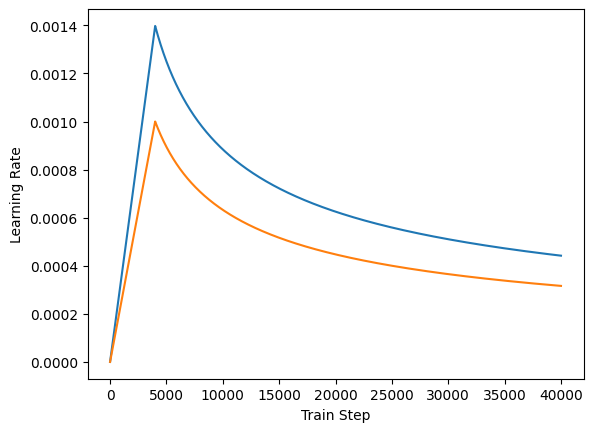

: 

In [ ]:
transformer_lr_schedule = TransformerLRSchedule(128, 4000)
warmup_lr_schedule = WarmupLRSchedule(0.0002, 4000)
plt.plot(transformer_lr_schedule(tf.range(40000, dtype=tf.float32)), label="TransformerLRSchedule")
plt.plot(warmup_lr_schedule(tf.range(40000, dtype=tf.float32)), label="WarmupLRSchedule")
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')